# COURSE: PCA and multivariate neural signal processing
## SECTION: Dimension reduction with PCA
### VIDEO: Python: PCA of simulated data
#### Instructor: sincxpress.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
from pytopo import topoplotIndie

In [2]:
## simulate data

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files/emptyEEG')
EEG = matfile['EEG'][0,0]
lf  = matfile['lf'][0,0]

# get chanloc XY values
x,y = [],[]
for i in range(int(EEG['nbchan'])):
    x.append(EEG['chanlocs'][0][i]['X'][0][0])
    y.append(EEG['chanlocs'][0][i]['Y'][0][0])


# index of dipole to simulate activity in
diploc = 109




# plot brain dipoles

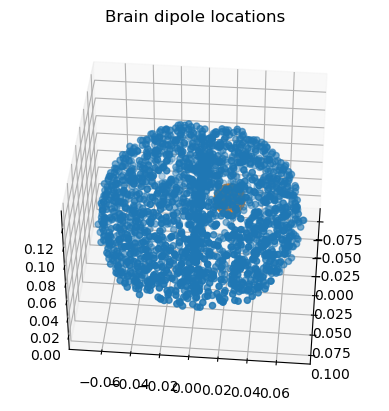

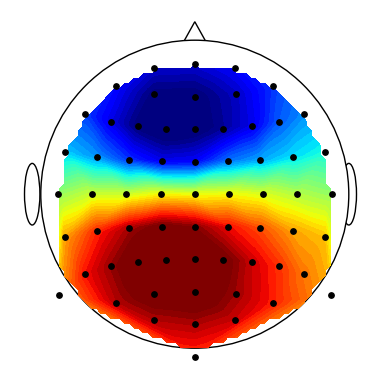

In [3]:
# setup figure
diploc = 1060
fig = pyplot.figure()
ax  = fig.add_subplot(projection='3d')
expandFac = 1

ax.view_init(40,5,0)
ax.scatter(lf['GridLoc'][:,0], lf['GridLoc'][:,1], lf['GridLoc'][:,2], 'bo')
ax.scatter(lf['GridLoc'][diploc-expandFac:diploc,0], lf['GridLoc'][diploc-expandFac:diploc,1], lf['GridLoc'][diploc-expandFac:diploc,2], marker='o',s=500)
plt.title('Brain dipole locations')
plt.show()


# Each dipole can be projected onto the scalp using the forward model. 
# The code below shows this projection from one dipole.
topoplotIndie(-lf['Gain'][:,0,diploc],EEG['chanlocs'])

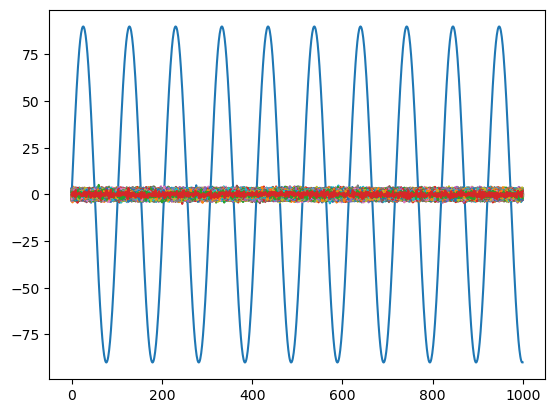

In [4]:
## create data

# number of time points and time vector
N = 1000
EEG['times'] = np.arange(0,N) / EEG['srate'][0]

lfshape = np.shape(lf['Gain'])

# Random data in all brain dipoles
dipole_data = np.random.randn(N,lfshape[2])

# add signal to second half of dataset
dipole_data[:,diploc] = 90*np.sin(2*np.pi*10*EEG['times'])

# project data from all dipoles to scalp electrodes
EEG['data'] = ( dipole_data@lf['Gain'][:,0,:].T ).T
plt.plot(dipole_data[:,:])
plt.show()

In [9]:
## compute PCA

# mean-center EEG data
data = EEG['data']
for ci in range(int(EEG['nbchan'])):
    data[ci,:] -= np.mean(data[ci,:])

# covariance matrix
covd = data@data.T / (len(EEG['times']))

# eigendecomposition
evals,evecs = np.linalg.eig( covd )

# sort according to eigenvalues
soidx = np.argsort(evals)
soidx = soidx[::-1]
evals = evals[soidx]
evecs = -evecs[:,soidx]

# convert eigenvalues to %change
evals = 100*evals / np.sum(evals)

evalSort = np.flip(np.argsort(evals))



# principal component time series
pc_timeseries = evecs[:,0].T@EEG['data']

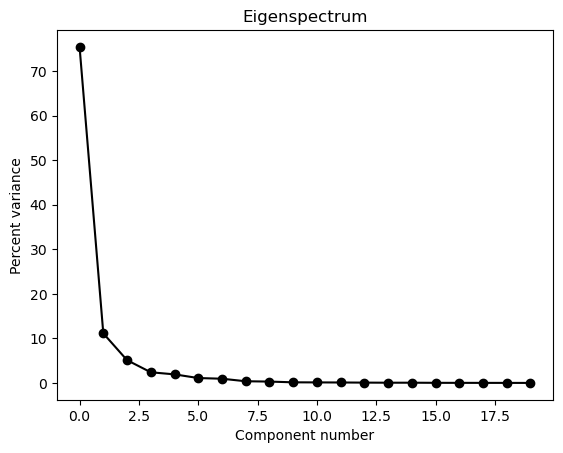

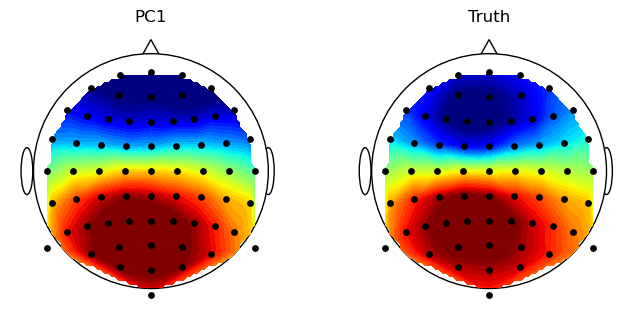

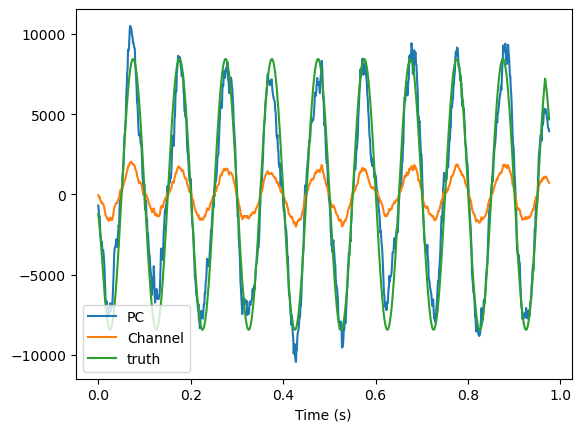

In [10]:
## plot results and compare with ground truth

# eigenspectrum
plt.plot(evals[0:20],'ko-')
plt.title('Eigenspectrum')
plt.ylabel('Percent variance')
plt.xlabel('Component number')
plt.show()


# topographical map of first eigenvector
_,axs = plt.subplots(1,2,figsize=(8,4))
topoplotIndie(evecs[:,0],EEG['chanlocs'],'PC1',axs[0])

# topographical map of dipole (ground truth)
topoplotIndie(-lf['Gain'][:,0,diploc],EEG['chanlocs'],'Truth',axs[1])
plt.show()


# plot time series
numSmth =20
smoothingKernal = np.ones(numSmth)/numSmth
smoothdata = lambda a: np.convolve(a,smoothingKernal,mode='same')
smthPC = smoothdata(pc_timeseries)
smthEEG = smoothdata(EEG['data'][30,:])
smthTruth = smoothdata(-dipole_data[:,diploc]*100)

plt.plot(EEG['times'],smthPC,label='PC')
plt.plot(EEG['times'],smthEEG,label='Channel')
plt.plot(EEG['times'],smthTruth,label='truth')
plt.legend()
plt.xlabel('Time (s)')
plt.show()